# Find clear scenes in high-resolution SST

### Choose a target region and time period, cycle through all available high-resolution sea surface temperature data, identify clear images, catalog them 



In [1]:
#!conda install -y -c conda-forge s3fs numpy pandas xarray matplotlib cartopy ipympl ipywidgets h5netcdf dask netCDF4 bottleneck

In [2]:
#!conda install -y -c conda-forge cartopy=0.21

In [3]:
import s3fs
import os
import os.path
import json
import warnings
import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

import sys
sys.path.append('../src')
import functions


import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.io.shapereader import Reader

warnings.filterwarnings("ignore")

# %matplotlib inline
# %matplotlib qt5
%matplotlib widget

# Define some functions

In [4]:
def plot_criterion_box(ax,**kwargs):
    """ Add a box to plots to show what box was used for the criterion.
         
    Inputs
    - matplotlib.pyplot.plot kwargs

    Return
    - exit code (True if OK)
    """

    coord = [[x1,y1], [x1,y2], [x2,y2], [x2,y1]]
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'

    xs, ys = zip(*coord) #create lists of x and y values

    if ax is None:
        ax = plt.gca()    
    # ax.plot(xs,ys,transform=ccrs.PlateCarree()) 
    ax.plot(xs,ys,**kwargs) 

    SF_lon=-(122+25/60)
    SF_lat= 37+47/60

    # mark a known place to help us geo-locate ourselves
    '''
    ax.plot(SF_lon, SF_lat, 'o', markersize=3, zorder=10, **kwargs)
    ax.text(SF_lon-5/60, SF_lat+5/60, 'San Francisco', fontsize=8, zorder=10, **kwargs)
    # ax.text(np.mean(xs)-.6, np.mean(ys)-.3, 'S-MODE ops area', fontsize=8, **kwargs)
    print(kwargs)
    '''

    return(xs,ys,ax)


In [5]:
swot_file = "../../S-MODE_analysis/data/SWOT_orbit/sph_calval_swath/swot_calval_orbit_june2015-v2_swath.shp"
nadir_file = "../../S-MODE_analysis/data/SWOT_orbit/shp_calval_nadir/swot_calval_orbit_june2015-v2_nadir.shp"
def plot_SWOT(ax):
    ax.add_geometries(Reader(swot_file).geometries(), ccrs.PlateCarree(), facecolor='white',alpha=0.15,edgecolor='k')
    ax.add_geometries(Reader(nadir_file).geometries(), ccrs.PlateCarree(), facecolor='none',linestyle='--',alpha=.5,edgecolor='k')
    return

## Set some parameters (start/end time)


In [6]:
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 400

savefig = True # set to true to save plots as file
!mkdir ../plots

__figdir__ = '../plots/'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}
plotfiletype='png'

mkdir: cannot create directory ‘../plots’: File exists


### Loading credentials for direct access

In [7]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [8]:
# Center location
#site = 'S-MODE'
#site = 'S-MODE IOP1'
site = 'S-MODE IOP2'
#site = 'SPURS-1'

if site == 'S-MODE':
    lon0 = -123.5
    lat0 = 37.5 
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'S-MODE IOP1':
    lon0 = -124.5
    lat0 = 37
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'S-MODE IOP2':
    lon0 = -124.5
    lat0 = 36.5
    dlon = 2.5 # half of box width in lon
    dlat = 2.0 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -125
    lat0 = 10
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-1':
    lon0 = -38
    lat0 = 25
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat

# Define the max/min lon
lon_min = lon0 - dlon
lon_max = lon0 + dlon
lat_min = lat0 - dlat
lat_max = lat0 + dlat

In [9]:
# Define a box where we want data (may be different than larger analysis domain)
# Still centered on lon0,lat0
dlon = 0.5 # half of box width in lon
dlat = 0.5 # half of box width in lat

# Define the max/min lon
x1 = lon0 - dlon
x2 = lon0 + dlon
y1 = lat0 - dlat
y2 = lat0 + dlat

In [10]:
if site == 'S-MODE':
    start_time = '2021-10-20T00:00:00Z'
    end_time = '2021-11-6T00:00:00Z'
elif site == 'S-MODE IOP1':
    start_time = '2022-10-01T00:00:00Z'#
    end_time = '2022-11-6T00:00:00Z'
elif site == 'S-MODE IOP2':
    start_time = '2021-04-01T00:00:00Z'#
    end_time = '2021-05-6T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2017-1-05T00:00:00Z'#'2016-8-20T00:00:00Z'
    end_time = '2017-11-6T00:00:00Z'
elif site == 'SPURS-1':
    start_time = '2012-12-15T00:00:00Z'#'2012-9-15T00:00:00Z'
    end_time = '2013-11-15T00:00:00Z'



Maybe try these:

https://podaac.jpl.nasa.gov/dataset/VIIRS_NPP-STAR-L3U-v2.80  
'C2147485059-POCLOUD' #VIIRS_NPP-STAR-L3U-v2.80

https://podaac.jpl.nasa.gov/dataset/VIIRS_N20-STAR-L3U-v2.80  
'C2147488020-POCLOUD' #VIIRS_N20-STAR-L3U-v2.80

In [11]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'


#concept_id = 'C2147488020-POCLOUD'; shortname= 'VIIRS_N20-STAR-L3U-v2.80'
concept_id = 'C2147485059-POCLOUD'; shortname= 'VIIRS_NPP-STAR-L3U-v2.80'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': start_time+','+end_time,
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 500,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )

granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][1]['href'])
# granules_url
len(granules_url)
print('Number of files found is ' + str(len(granules_url)))
if len(granules_url) == 500:
    print('Max number of files returned. There may be more files.  Try shortening time window.')

Number of files found is 196


In [12]:
# There is an inconvenient issue with these files.  The correct link is not in the same place for each of the granules
# This was an attempt to fix the issue by just dropping the md5 suffix.  That almost works, but the prefix should be something like:  
# s3://podaac-ops-cumulus-protected/ 
# and not:  
# s3://podaac-ops-cumulus-public/

granules_url2 = []
for gran in granules_url:
    #print(gran.replace('.md5',''))
    gran2 = gran.replace('.md5','')
    #print(gran2[gran2.index('/VIIRS'):])
    granules_url2.append('s3://podaac-ops-cumulus-protected'+gran2[gran2.index('/VIIRS'):])


In [13]:
file_list =  [fs.open(file) for file in granules_url2]

In [14]:
ds = xr.open_mfdataset(file_list,drop_variables=['dt_analysis','satellite_zenith_angle','sses_bias','wind_speed']).sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min))

## Make a metric to select times with clear skies in region of interest

The idea here is to choose a box defining region of interest and use quality flag or NaN mask to count bad/good pixels


In [15]:
# Make a time series in that box
# Compute mean value of "not NaN" (notnull) in the box
good_data = ds.sea_surface_temperature.sel(lat=slice(y2,y1), lon=slice(x1,x2)).notnull().mean({'lon','lat'})
np.shape(good_data)

(196,)

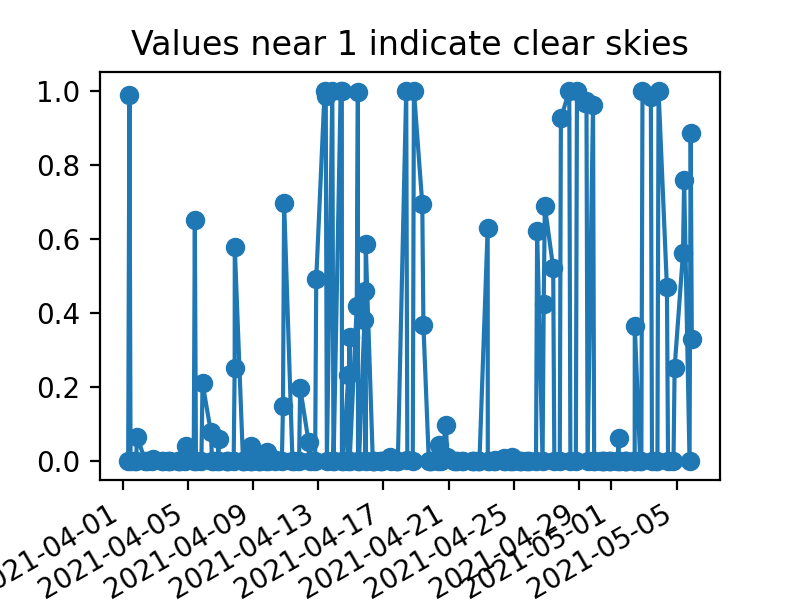

In [16]:
fig = plt.figure(figsize=(4,3),dpi=200)
plt.plot(good_data['time'],good_data,marker='o')
fig.autofmt_xdate()
plt.title('Values near 1 indicate clear skies')

# Export figure
if savefig:
    plt.savefig(__figdir__+'good_data_' + shortname + '.' +plotfiletype,**savefig_args)

In [17]:
good_times = good_data['time'].where(good_data>0.8,drop=True)
np.shape(good_times)

(19,)

In [20]:
## Choose a particular time
# Find the data near this time
d = good_times[5] # np.datetime64('2021-11-05T00:00:00Z')

ds2 = ds.sel(time=d,method='nearest')

# This string of the time of the SST selected will be useful
day_str = np.datetime_as_string(ds2.time,unit='m')

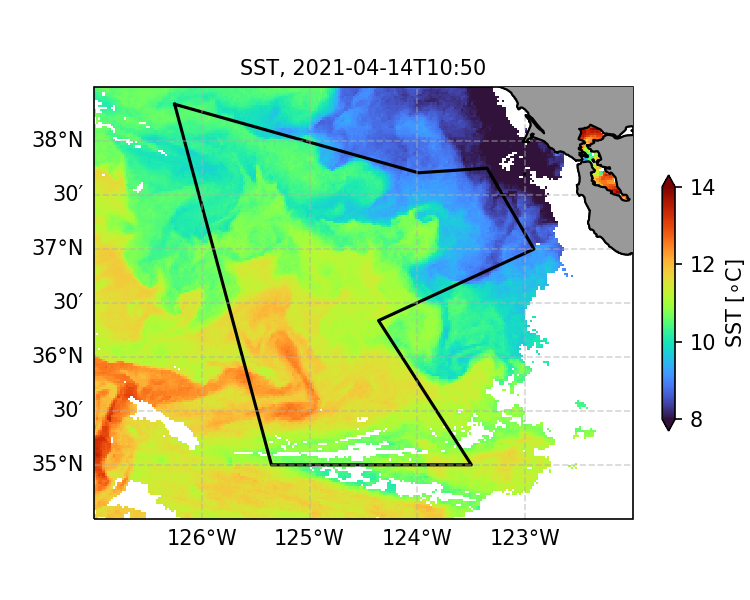

In [22]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())


plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('SST, ' + day_str, size = 10.)

# Does not do what I think it should:
ax.minorticks_on()
ax.tick_params(axis='both',which='both',direction='inout',top=True, right=True)


ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze()-274.15,vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('SST [$\circ$C]',fontsize = 10)
functions.plot_ops_area_IOP2(ax,transform=ccrs.PlateCarree(),color='k')
plot_SWOT(ax)

# Export figure
if savefig:
    plt.savefig(__figdir__+'map_' + shortname + '.' +plotfiletype,**savefig_args)

# Next steps for this script and S-MODE processing

Features wanted:
1. Loop through good images and plot.  
2. Save images.  
3. Extract subset of good data and save as netcdf.  


In [24]:
# Extract a data set with only "good times"
if 1==2:
    good_times = good_data['time'].where(good_data>0.5,drop=True)
    print(np.shape(good_times))

    d = good_times # np.datetime64('2021-11-05T00:00:00Z')
    ds3 = ds.sel(time=d,method='nearest')

    ds3

In [25]:
# Write the subsetted data set to a netcdf file
# ds3.to_netcdf('outfile.nc',format="NETCDF4")